In [1]:
import itertools
import librosa
import scipy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa.display
from data.IEMOCAP import IEMOCAP
from data.COMMANDS import COMMANDS
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.autograd import Variable

class LearnedGroupConv1D(nn.Module):
    global_progress = 0.0
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, condense_factor=None, dropout_rate=0.):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.condense_factor = condense_factor
        self.groups = groups
        self.dropout_rate = dropout_rate

        # Check if given configs are valid
        assert self.in_channels % self.groups == 0, "group value is not divisible by input channels"
        assert self.in_channels % self.condense_factor == 0, "condensation factor is not divisible by input channels"
        assert self.out_channels % self.groups == 0, "group value is not divisible by output channels"

        self.conv = nn.Conv1d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, dilation=dilation, groups=1, bias=True)
        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(self.dropout_rate, inplace=False)
        # register conv buffers
        self.register_buffer('_count', torch.zeros(1))
        self.register_buffer('_stage', torch.zeros(1))
        self.register_buffer('_mask', torch.ones(self.conv.weight.size()))

    def forward(self, x):
        # To mask the output
        weight = self.conv.weight * self.mask
        weight_bias = self.conv.bias
        out = F.conv1d(input=x, weight=weight, bias=weight_bias, stride=self.conv.stride, 
                            padding=self.conv.padding, dilation=self.conv.dilation, groups=1)
        ## Dropping here ##
        self.check_if_drop()
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out

    """
    Paper: Sec 3.1: Condensation procedure: number of epochs for each condensing stage: M/2(C-1)
    Paper: Sec 3.1: Condensation factor: allow each group to select R/C of inputs.
    - During training a fraction of (C−1)/C connections are removed after each of the C-1 condensing stages
    - we remove columns in Fg (by zeroing them out) if their L1-norm is small compared to the L1-norm of other columns.
    """
    def check_if_drop(self):
        current_progress = LearnedGroupConv1D.global_progress
        delta = 0
        # Get current stage
        for i in range(self.condense_factor - 1):   # 3 condensation stages
            if current_progress * 2 < (i + 1) / (self.condense_factor - 1):
                stage = i
                break
        else:
            stage = self.condense_factor - 1
        # Check for actual dropping
        if not self.reach_stage(stage):
            self.stage = stage
            delta = self.in_channels // self.condense_factor
            print(delta)
        if delta > 0:
            self.drop(delta)
        return

    def drop(self, delta):
        weight = self.conv.weight * self.mask
        # Sum up all kernels
        print(weight.size())
        assert weight.size()[-1] == 1
        weight = weight.abs().squeeze()
        assert weight.size()[0] == self.out_channels
        assert weight.size()[1] == self.in_channels
        d_out = self.out_channels // self.groups
        print(d_out.size())
        # Shuffle weights
        weight = weight.view(d_out, self.groups, self.in_channels)
        print(weight.size())

        weight = weight.transpose(0, 1).contiguous()
        print(weight.size())

        weight = weight.view(self.out_channels, self.in_channels)
        print(weight.size())
        # Sort and drop
        for i in range(self.groups):
            wi = weight[i * d_out:(i + 1) * d_out, :]
            # Take corresponding delta index
            di = wi.sum(0).sort()[1][self.count:self.count + delta]
            for d in di.data:
                self._mask[i::self.groups, d, :, :].fill_(0)
        self.count = self.count + delta

    def reach_stage(self, stage):
        return (self._stage >= stage).all()

    @property
    def count(self):
        return int(self._count[0])

    @count.setter
    def count(self, val):
        self._count.fill_(val)

    @property
    def stage(self):
        return int(self._stage[0])

    @stage.setter
    def stage(self, val):
        self._stage.fill_(val)

    @property
    def mask(self):
        return Variable(self._mask)

def _bn_function_factory(conv, norm, prelu):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = norm(prelu(conv(concated_features)))
        return bottleneck_output

    return bn_function

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate):
        super(_DenseLayer, self).__init__()
        
        self.conv0 = LearnedGroupConv1D(num_input_features, 4 * growth_rate, kernel_size=3, padding=1, groups=4, condense_factor=4)
        self.norm0 = nn.BatchNorm1d(4 * growth_rate)

        self.PReLU = nn.PReLU(num_parameters=1, init=0.05)
        
        self.conv1 = LearnedGroupConv1D(4 * growth_rate, growth_rate, kernel_size=3, padding=1, groups=8, condense_factor=8)
        self.norm1 = nn.BatchNorm1d(growth_rate)

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.conv0, self.norm0, self.PReLU)
        if any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.norm1(self.conv1(bottleneck_output))
        return new_features
    
class _DenseBlock(nn.Module):
    def __init__(self, nChannels, growth_rate):
        super(_DenseBlock, self).__init__()
        layer = _DenseLayer(nChannels, growth_rate)
        self.add_module('denselayer', layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class EdgeRNN(nn.Module):
    def __init__(self, num_class):
        super(EdgeRNN, self).__init__()

        self.output_size = num_class
        num_features = 152
        growth_rate = 16
        
#         self.conv0 = LearnedGroupConv1D(num_features, num_features, kernel_size=1, padding=0, groups=4, condense_factor=4)
        self.dense1 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense2 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense3 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense4 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense5 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense6 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense7 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense8 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense9 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense10 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense11 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense12 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        
        self.MaxPool1d = nn.MaxPool1d(2,2)
        
        self.RNN = nn.RNN(num_features, num_features, 1, batch_first=True,
                              dropout=0,bidirectional=False)
        self.Tanh = nn.Tanh()
        self.out = nn.Linear(num_features, self.output_size)

    
    def forward(self, x):
        
        x = x.float()
        
#         x = self.conv0(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        x = self.dense9(x)
        x = self.dense10(x)
        x = self.dense11(x)
        x = self.dense12(x)
        
        x = self.MaxPool1d(x)
        
        x = x.permute(0, 2, 1)
        x, h_n = self.RNN(x)
        
        residual = x 
        x = F.sigmoid(x)
        residual = residual * x
        residual = (residual.sum(1)) / (x.sum(1))
        residual = self.Tanh(residual)

        x = self.out(residual)
        
        return x

In [2]:
def confusion_matrix(preds, y, NUM_CLASSES):
    """ Returns confusion matrix """
    assert preds.shape[0] == y.shape[0], "1 dim of predictions and labels must be equal"
    rounded_preds = torch.argmax(preds,1)
    conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
    for i in range(rounded_preds.shape[0]):
        predicted_class = rounded_preds[i]
        correct_class = y[i]
        conf_mat[correct_class][predicted_class] += 1
    return conf_mat

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

This is IEMOCAP


/root/anaconda3/lib/python3.6/site-packages/torch/backends/cudnn/__init__.py:115: UserWarning: PyTorch was compiled without cuDNN support. To use cuDNN, rebuild PyTorch making sure the library is visible to the build system.
  "PyTorch was compiled without cuDNN support. To use cuDNN, rebuild "
/root/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1397: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[[207.  12.  27.  82.]
 [ 47. 148.   6.  20.]
 [ 39.   4. 138.  36.]
 [ 70.  19.  41. 212.]]
Normalized confusion matrix
[[0.63109756 0.03658537 0.08231707 0.25      ]
 [0.21266968 0.66968326 0.02714932 0.09049774]
 [0.1797235  0.01843318 0.6359447  0.16589862]
 [0.20467836 0.05555556 0.11988304 0.61988304]]


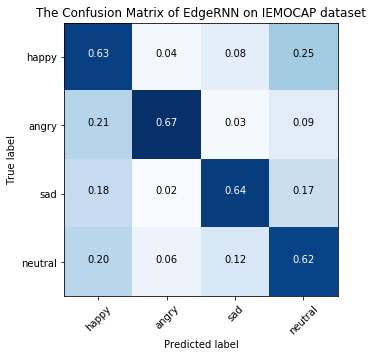

In [3]:
print ("This is IEMOCAP")
NUM_CLASSES = 4
PrivateTestset = IEMOCAP(split = 'PrivateTest')
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=64, shuffle=False, num_workers=1)

net = EdgeRNN(num_class=NUM_CLASSES) 
Private_checkpoint = torch.load('IEMOCAP_Test_model.pt')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)

    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
attack_types = ['happy', 'angry', 'sad', 'neutral']
plt.figure(figsize=(5, 5))
plot_confusion_matrix(conf_mat, classes=attack_types, normalize=True, title='The Confusion Matrix of EdgeRNN on IEMOCAP dataset')
plt.show()
plt.close()

This is COMMANDS
[[8.128e+03 5.000e+00 5.000e+00 1.400e+01 9.000e+00 5.000e+00 1.400e+01
  1.200e+01 6.000e+00 9.000e+00 1.200e+01]
 [1.500e+01 4.560e+02 1.000e+00 0.000e+00 1.000e+00 3.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.900e+01 2.000e+00 4.430e+02 0.000e+00 6.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 1.000e+01]
 [1.600e+01 0.000e+00 0.000e+00 4.490e+02 0.000e+00 1.000e+00 0.000e+00
  2.000e+00 6.000e+00 1.000e+00 0.000e+00]
 [3.500e+01 0.000e+00 4.000e+00 0.000e+00 4.300e+02 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 2.000e+00]
 [2.300e+01 2.000e+00 0.000e+00 1.000e+00 0.000e+00 4.440e+02 0.000e+00
  1.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [3.300e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 4.400e+02
  0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [4.000e+01 0.000e+00 0.000e+00 2.000e+00 1.000e+00 0.000e+00 0.000e+00
  4.220e+02 2.000e+00 0.000e+00 0.000e+00]
 [2.100e+01 1.000e+00 0.000e+00 1.500e+01 0.000e+00 0.000e+00 0

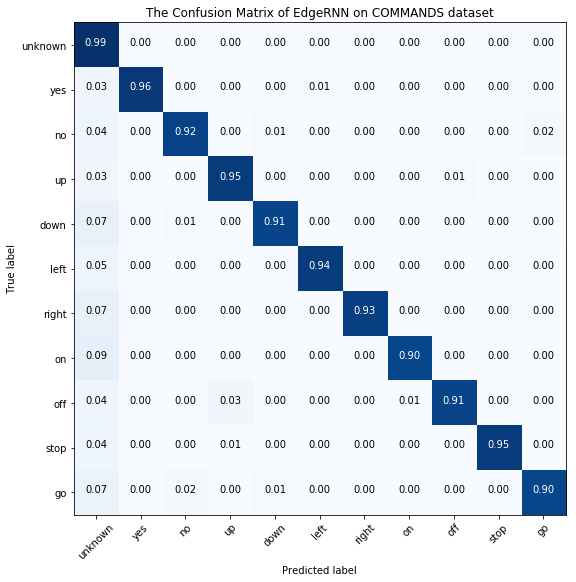

In [4]:
print ("This is COMMANDS")
NUM_CLASSES = 11
PrivateTestset = COMMANDS(split = 'PrivateTest')
PrivateTestloader = torch.utils.data.DataLoader(PrivateTestset, batch_size=64, shuffle=False, num_workers=1)

net = EdgeRNN(num_class=NUM_CLASSES) 
Private_checkpoint = torch.load('COMMANDS_Test_model.pt')
net.load_state_dict(Private_checkpoint['net'], strict=False)

net.cuda()
net.eval()
conf_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))
for batch_idx, (inputs, targets) in enumerate(PrivateTestloader):
    
    inputs, targets = inputs.cuda(), targets.cuda()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)

    conf_mat += confusion_matrix(outputs, targets, NUM_CLASSES)
print (conf_mat)
attack_types = ['unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat, classes=attack_types, normalize=True, title='The Confusion Matrix of EdgeRNN on COMMANDS dataset')
plt.show()
plt.close()